In [20]:
import sys
sys.path.insert(0, '..')

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from caviar import CaviarModel
from var_tests import *

In [22]:
df = pd.read_csv('dataCAViaR.txt', header=None, sep='\t')
df.columns = ['GM', 'IBM', 'SP500']
in_samples = df[:-500]
out_samples = df[-500:]

In [23]:
tickers = ['GM', 'IBM', 'SP500']
quantiles = [.01, .05]
models = ['symmetric', 'asymmetric', 'igarch', 'adaptive']

In [24]:
beta_table = []
performance_table = []

for mod in models:
    for ticker in tickers:
        for q in [.05, .01]:        
            caviar_model = CaviarModel(q, model=mod, method='RQ')
            caviar_model.fit(in_samples[ticker])
            
            in_VaRs = caviar_model.predict(in_samples[ticker], 'in')
            in_VaRs = in_VaRs[:-1] # last 1 is the forecast
            
            out_VaRs = caviar_model.predict(out_samples[ticker], 'out')
            out_VaRs = out_VaRs[:-1] # last 1 is the forecast
            
            beta_record = caviar_model.beta_summary()
            beta_record['model'] = mod
            beta_record['ticker'] = ticker
            beta_record['quantile'] = q
            beta_table.append(beta_record)
            
            performance_table.append({
                'model': mod,
                'ticker': ticker,
                'quantile': q,
                'hit_in': hit_rate(in_samples[ticker], in_VaRs),
                'hit_out': hit_rate(out_samples[ticker], out_VaRs),
                'dq_in': caviar_model.dq_test(in_samples[ticker], 'in'),
                'dq_out': caviar_model.dq_test(out_samples[ticker], 'out'),
            })

Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 2.107629597530627
Update 1: 0.1917747593121134
Update 2: 0.19063422081305043
Update 3: 0.19063244504283508
Update 4: 0.19063244292605833
Update 5: 0.1906324345041507
Final loss: 0.1906324345041507
Time taken(s): 1.83
Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 1.8505488945662922
Update 1: 0.05894397809735506
Update 2: 0.05894397809733536
Final loss: 0.05894397809733536
Time taken(s): 1.73
Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 3.5740710368665107
Update 1: 0.1803416144226532
Update 2: 0.18034161328670179
Update 3: 0.18034161328670179
Final loss: 0.1803416144226532
Time taken(s): 1.08
Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 2.239115959310583
Update 1: 0.06334495714500094
Update 2: 0.06334490207268668
Update 3: 0.06334490205033252
Final loss: 0.06334490205033252
Time taken(s): 1.19
Generating 1 best

D:\CAViaR-Project\poc\..\caviar\_caviar_function.py:22: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(G * (returns[t] - VaRs[t]))) - quantile


Time taken(s): 0.99
Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 581.8075713892435
Update 1: 0.06211805767941255
Update 2: 0.06211805767941255
Final loss: 0.06211805767941255
Time taken(s): 1.11
Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 3.205469814598621


D:\CAViaR-Project\poc\..\caviar\_caviar_function.py:22: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(G * (returns[t] - VaRs[t]))) - quantile


Update 1: 0.18247427577389222
Update 2: 0.18247427577389222
Final loss: 0.18247427577389222
Time taken(s): 0.40
Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 576.3395512710231
Update 1: 0.0665224830480905
Update 2: 0.06652248304543126
Final loss: 0.06652248304543126
Time taken(s): 1.00
Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 0.8430082092324533
Update 1: 0.10791885241553038
Update 2: 0.10791885241553038
Final loss: 0.10791885241553038
Time taken(s): 0.31
Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 399.173739441385
Update 1: 0.040605301352991605
Update 2: 0.040605301352991605
Final loss: 0.040605301352991605
Time taken(s): 0.34


## Beta Statistics

In [25]:
beta_table = pd.concat(beta_table).reset_index()
beta_table = beta_table.rename(columns={'index': 'beta'})

In [26]:
result_table = {}


for q in quantiles:
    cond1 = beta_table['quantile'] == q
    for mod in models:
        cond2 = beta_table['model'] == mod
        for ticker in tickers:
            cond3 = beta_table['ticker'] == ticker
            result_table[(q, mod, ticker)] = {}
            
            for beta in beta_table.beta.unique():
                cond4 = beta_table['beta'] == beta
                row = beta_table[cond1&cond2&cond3&cond4]
                
                if len(row) != 0:
                    result_table[(q, mod, ticker)][(beta, 'coefficient')] = row['coefficient'].values[0]
                    result_table[(q, mod, ticker)][(beta, 'S.E. of beta')] = row['S.E. of beta'].values[0]
                    result_table[(q, mod, ticker)][(beta, 'pval of beta')] = row['pval of beta'].values[0]
                else:
                    result_table[(q, mod, ticker)][(beta, 'coefficient')] = ''#np.nan
                    result_table[(q, mod, ticker)][(beta, 'S.E. of beta')] = ''#np.nan
                    result_table[(q, mod, ticker)][(beta, 'pval of beta')] = ''#np.nan

## Performances(hit and DQ)

In [27]:
performance_table = pd.DataFrame(performance_table)

In [28]:
result_table2 = {}


for q in quantiles:
    cond1 = performance_table['quantile'] == q
    for mod in models:
        cond2 = performance_table['model'] == mod
        for ticker in tickers:
            cond3 = performance_table['ticker'] == ticker
            result_table2[(q, mod, ticker)] = {}
            
            for stat in performance_table.columns[-4:]:
                result_table2[(q, mod, ticker)][(stat.split('_')[0], stat.split('_')[1])] = performance_table[cond1&cond2&cond3][stat].values[0]

## Table in literature

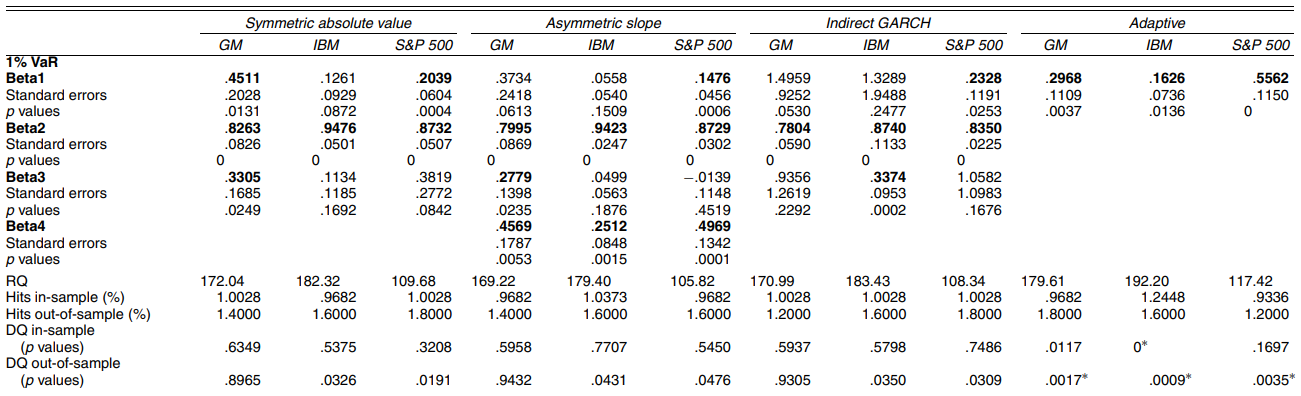

In [29]:
pd.concat([pd.DataFrame(result_table)[0.01],
           pd.DataFrame(result_table2)[0.01]]).round(6)

symmetric                     asymmetric            \
                          GM       IBM     SP500         GM       IBM   
beta1 coefficient  -0.343911 -0.727897 -0.004608  -0.390809 -0.789185   
      S.E. of beta  0.216131  0.619478  0.034973   0.250784  0.286135   
      pval of beta   0.05578  0.119994  0.447593   0.059575  0.002907   
beta2 coefficient   0.816073  0.722504  0.959111   0.798864  0.752996   
      S.E. of beta  0.079019  0.160866  0.026255   0.089985  0.088569   
      pval of beta       0.0  0.000004       0.0   0.000000  0.000000   
beta3 coefficient  -0.346868 -0.349468 -0.145118  -0.271471 -0.018197   
      S.E. of beta  0.151916   0.09702  0.028091   0.147614  0.107749   
      pval of beta  0.011207  0.000158       0.0   0.032953  0.432942   
beta4 coefficient                                  0.446390  0.338038   
      S.E. of beta                                 0.152497  0.092921   
      pval of beta                                 0.001710  0.000137   
hit   in            0.010028  0.010028  0.010028   0.010028  0.009682   
      out               0.01     0.018      0.01   0.014000  0.018000   
dq    in            0.662104  0.413324  0.739716   0.602726  0.593631   
      out            0.79749  0.047654  0.002914   0.943434  0.000000   

                                igarch                      adaptive  \
                       SP500        GM       IBM     SP500        GM   
beta1 coefficient  -0.388998  1.031854  0.914028  0.237697  -0.30429   
      S.E. of beta  0.135755  0.926779  1.503815  0.139215  0.093027   
      pval of beta  0.002082  0.132773  0.271658  0.043873  0.000536   
beta2 coefficient   0.759763  0.820621  0.899612  0.838169             
      S.E. of beta  0.074280  0.098293  0.107839  0.051162             
      pval of beta  0.000000       0.0       0.0       0.0             
beta3 coefficient   0.067730  0.782245   0.33217       1.0             
      S.E. of beta  0.096139  0.422417  0.201785  0.754929             
      pval of beta  0.240559  0.032025  0.049866  0.092647             
beta4 coefficient   0.621129                                           
      S.E. of beta  0.203686                                           
      pval of beta  0.001146                                           
hit   in            0.010028  0.010373  0.010028  0.010373  0.010719   
      out           0.022000     0.012     0.014     0.018     0.018   
dq    in            0.910484  0.653738  0.481468  0.664182  0.001342   
      out           0.003870   0.92551  0.026796  0.030658  0.001709   

                                        
                         IBM     SP500  
beta1 coefficient  -0.162978 -0.551783  
      S.E. of beta  0.082391  0.122473  
      pval of beta  0.023959  0.000003  
beta2 coefficient                       
      S.E. of beta                      
      pval of beta                      
beta3 coefficient                       
      S.E. of beta                      
      pval of beta                      
beta4 coefficient                       
      S.E. of beta                      
      pval of beta                      
hit   in            0.012102  0.009682  
      out              0.016     0.012  
dq    in                 0.0  0.201943  
      out           0.000946  0.003468

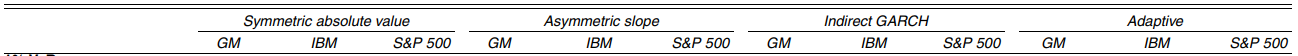

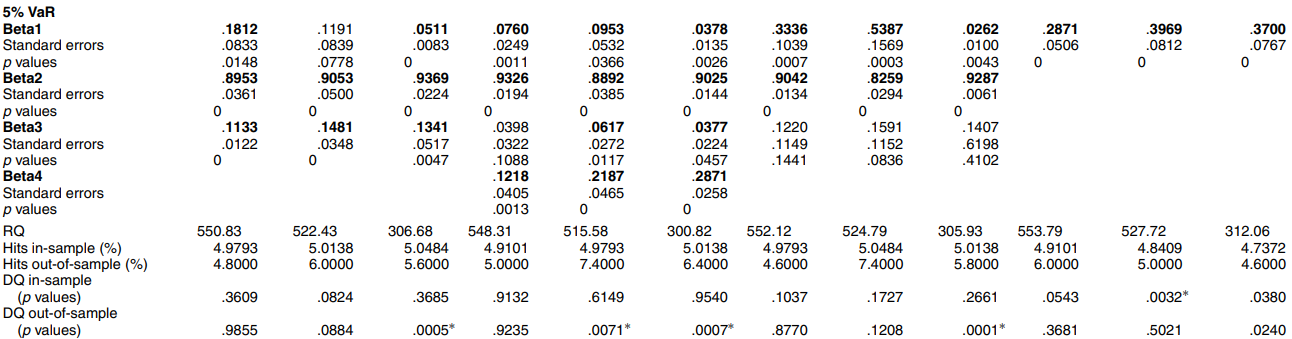

In [30]:
pd.concat([pd.DataFrame(result_table)[0.05],
           pd.DataFrame(result_table2)[0.05]]).round(6)

symmetric                     asymmetric            \
                          GM       IBM     SP500         GM       IBM   
beta1 coefficient  -0.150737 -0.039897 -0.009705  -0.073809 -0.093953   
      S.E. of beta  0.091759  0.055434  0.006353   0.022678  0.046810   
      pval of beta  0.050218  0.235851  0.063292   0.000568  0.022370   
beta2 coefficient   0.888571   0.91719  0.951531   0.933917  0.890119   
      S.E. of beta  0.040078  0.036317  0.032078   0.018104  0.033098   
      pval of beta       0.0       0.0       0.0   0.000000  0.000000   
beta3 coefficient  -0.113873 -0.137236 -0.087476  -0.038275 -0.061331   
      S.E. of beta  0.013051  0.028557  0.066832   0.030102  0.023736   
      pval of beta       0.0  0.000001  0.095285   0.101777  0.004885   
beta4 coefficient                                  0.121172  0.217797   
      S.E. of beta                                 0.039696  0.039882   
      pval of beta                                 0.001135  0.000000   
hit   in            0.050138  0.049793  0.049793   0.050138  0.049793   
      out              0.044     0.056     0.054   0.050000  0.074000   
dq    in            0.396925  0.231809  0.390634   0.931435  0.612866   
      out           0.995229  0.370055  0.000337   0.923369  0.007012   

                                igarch                      adaptive  \
                       SP500        GM       IBM     SP500        GM   
beta1 coefficient  -0.076046  0.333025  0.654124  0.025224 -0.287051   
      S.E. of beta  0.028926  0.090095  0.297861  0.009192  0.046082   
      pval of beta  0.004282  0.000109  0.014044  0.003035       0.0   
beta2 coefficient   0.861083  0.904176  0.792916  0.929927             
      S.E. of beta  0.046339   0.02917  0.071183  0.027086             
      pval of beta  0.000000       0.0       0.0       0.0             
beta3 coefficient  -0.020566  0.122122  0.178295  0.136191             
      S.E. of beta  0.045064  0.079601  0.045181  0.092754             
      pval of beta  0.324065  0.062494   0.00004  0.071011             
beta4 coefficient   0.361998                                           
      S.E. of beta  0.070783                                           
      pval of beta  0.000000                                           
hit   in            0.050138  0.050484  0.050138   0.05083  0.049101   
      out           0.078000     0.046     0.076     0.058      0.06   
dq    in            0.822630  0.189441  0.251199  0.335978  0.054116   
      out           0.002781   0.87697  0.035645  0.000074  0.368134   

                                        
                         IBM     SP500  
beta1 coefficient  -0.397012  -0.37077  
      S.E. of beta  0.079782  0.085425  
      pval of beta       0.0  0.000007  
beta2 coefficient                       
      S.E. of beta                      
      pval of beta                      
beta3 coefficient                       
      S.E. of beta                      
      pval of beta                      
beta4 coefficient                       
      S.E. of beta                      
      pval of beta                      
hit   in            0.048409  0.047372  
      out               0.05     0.046  
dq    in            0.003135  0.038697  
      out           0.502242  0.023979